# Automatic Game Balancing with Top Trumps

Install required packages:

In [1]:
%pip install numpy pymoo

Note: you may need to restart the kernel to use updated packages.


## Configuration

All configurable parameters for the optimization run:

In [2]:
# === CONFIGURATION ===

# Problem parameters (from assignment)
NUM_CARDS = 22              # K: number of cards in deck
NUM_CATEGORIES = 4          # L: number of categories per card
N_SIMULATIONS = 1000        # R: simulations per evaluation (final run)
N_SIMULATIONS_DEV = 100     # R: simulations per evaluation (development)
VALUE_BOUNDS = (1.0, 10.0)  # Card value bounds

# Algorithm parameters
POP_SIZE = 100              # Population size for NSGA-II
N_GEN = 100                 # Number of generations
SEED = 42                   # Random seed for reproducibility
CROSSOVER_PROB = 0.9        # SBX crossover probability
CROSSOVER_ETA = 15          # SBX distribution index
MUTATION_ETA = 20           # Polynomial mutation distribution index

# Runtime settings
DEV_MODE = False             # True: use N_SIMULATIONS_DEV (faster), False: use N_SIMULATIONS
VERBOSE = True              # Print progress during optimization
SAVE_HISTORY = True         # Store algorithm state each generation (for convergence analysis)

# Output settings
OUTPUT_DIR = "./results"    # Directory for saving results

# Derived values
N_VAR = NUM_CARDS * NUM_CATEGORIES  # Total decision variables (88)
R = N_SIMULATIONS_DEV if DEV_MODE else N_SIMULATIONS

print(f"Configuration:")
print(f"  Problem: {NUM_CARDS} cards × {NUM_CATEGORIES} categories = {N_VAR} variables")
print(f"  Simulations per evaluation: {R} ({'DEV' if DEV_MODE else 'FINAL'})")
print(f"  Algorithm: NSGA-II with pop_size={POP_SIZE}, n_gen={N_GEN}")
print(f"  Total evaluations: ~{POP_SIZE * N_GEN:,}")

Configuration:
  Problem: 22 cards × 4 categories = 88 variables
  Simulations per evaluation: 1000 (FINAL)
  Algorithm: NSGA-II with pop_size=100, n_gen=100
  Total evaluations: ~10,000


## Top Trumps Implementation

In [3]:
import random
import numpy as np

class TopTrumpsSimulation:
    """TopTrumpsSimulation implements the basic TopTrumps game engine and agent-based simulation."""

    def __init__(self, num_cards=52, num_categories=6):
        self.K = num_cards  # Number of cards
        self.L = num_categories  # Number of categories

        self.set_random_deck()

    def _normalize_deck(self, deck):
        """Normalizes the deck such that each property is in the range [0,1]. This is required for the p0 agent."""
        min_values = [0] * self.L
        max_values = [0] * self.L

        for cat in range(self.L):
            all_values = [card[cat] for card in deck]
            min_values[cat] = min(all_values)
            max_values[cat] = max(all_values)

        normalized_deck = []

        for card in deck:
            normalized_card = [0] * self.L
            for cat in range(self.L):
                normalized_card[cat] = (card[cat] - min_values[cat]) / (max_values[cat] - min_values[cat])
            normalized_deck.append(normalized_card)

        return normalized_deck

    def set_deck(self, deck_list):
        """Creates a deck from deck_list of length K*L."""

        assert len(deck_list) == self.K * self.L

        deck = np.array_split(deck_list, self.K)

        self.deck = deck
        self._normalized_deck = self._normalize_deck(deck)

    def set_random_deck(self, value_range = (1, 10)):
        """Generates a random deck with values in value_range."""
        deck_list = np.random.uniform(value_range[0], value_range[1], self.K * self.L)
        self.set_deck(deck_list)

    def get_p0_choice(self, card):
        """p0 assumes uniform distribution between max and min values per property and then picks the best value on current card."""
        return card.index(max(card))

    def get_p4_choice(self, card, remaining_cards):
        """p4 calculates exact win probability based on remaining cards."""
        best_prob = -1
        best_cat = 0

        for cat_idx in range(self.L):
            my_val = card[cat_idx]
            # Count how many cards in the potential card pool have a lower value
            wins = sum(1 for opp_card in remaining_cards if my_val > opp_card[cat_idx])
            prob = wins / len(remaining_cards)

            if prob > best_prob:
                best_prob = prob
                best_cat = cat_idx
        # print(f"Best prob: {best_prob:.2f}, cat: {best_cat}")
        return best_cat

    def simulate_game(self):
        # Shuffle and distribute cards
        temp_deck = list(self._normalized_deck)
        random.shuffle(temp_deck)

        # p4 vs p0 setup
        p4_hand = temp_deck[:self.K//2]
        p0_hand = temp_deck[self.K//2:]

        # Track unplayed cards remaining in the 'unplayed' pool for p4's knowledge 
        all_unplayed = list(temp_deck) 

        p4_tricks = 0
        current_turn = random.choice(['p4', 'p0']) # Random starting player
        trick_changes = 0

        # Game ends after all cards played once
        for i in range(self.K // 2):
            card_p4 = p4_hand[i]
            card_p0 = p0_hand[i]

            # Category Selection
            if current_turn == 'p4':
                category = self.get_p4_choice(card_p4, all_unplayed)
            else:
                category = self.get_p0_choice(card_p0)

            # Determine Round Winner
            val_p4 = card_p4[category]
            val_p0 = card_p0[category]

            # Remove current p0, p4 card from p4's tracking memory
            all_unplayed.remove(card_p0)
            all_unplayed.remove(card_p4)

            if val_p4 > val_p0:
                # print("P4 wins!")
                p4_tricks += 1
                if current_turn == 'p0':
                    current_turn = 'p4'
                    trick_changes += 1
            elif val_p0 > val_p4:
                # print("P0 wins!")
                if current_turn == 'p4':
                    current_turn = 'p0'
                    trick_changes += 1
            # In case of draw, current player keeps the lead

        return {
            "p4_tricks": p4_tricks,
            "trick_changes": trick_changes,
            "p4_won": p4_tricks > (self.K / 4) # p4 wins if they got more than half the tricks
        }

Test implementation on a random deck:

In [4]:
num_cards = 22
num_categories = 4
num_repetitions = 1000

sim = TopTrumpsSimulation(num_cards=num_cards, num_categories=num_categories)
sim.set_deck(np.random.uniform(0, 10, num_cards * num_categories))
results = [sim.simulate_game() for _ in range(num_repetitions)]

avg_p4_win_rate = sum(1 for r in results if r['p4_won']) / num_repetitions
avg_tricks = sum(r['p4_tricks'] for r in results) / num_repetitions
avg_trick_changes = sum(r['trick_changes'] for r in results) / num_repetitions

print(f"Results over {num_repetitions} runs:")
print(f"p4 Win Rate: {avg_p4_win_rate:.2%}")
print(f"Average p4 Tricks: {avg_tricks:.2f}")
print(f"Average Trick Changes: {avg_trick_changes:.2f}")

Results over 1000 runs:
p4 Win Rate: 57.20%
Average p4 Tricks: 5.98
Average Trick Changes: 2.29


## Pymoo connection

TopTrumpsBalancing provides a pymoo-compatible interface for TopTrumpsSimulation. Note that the objectives are already negated to result in a minimization problem!

In [5]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class TopTrumpsBalancing(ElementwiseProblem):
    """TopTrumpsBalancing connects TopTrumpsSimulation with the pymoo interface ElementwiseProblem."""

    def __init__(self, sim_instance, n_simulations=100):
        self.sim = sim_instance
        self.n_simulations = n_simulations
        
        # KL variables: Number of cards (K) * Categories (L) 
        n_var = self.sim.K * self.sim.L
        
        super().__init__(n_var=n_var,
                         n_obj=2, # Objectives: Fairness (p4 win rate) and Excitement (# trick changes)
                         n_constr=0,
                         xl=1.0, # Lower bound for values
                         xu=10.0) # Upper bound for values

    def _evaluate(self, x, out, *args, **kwargs):
        # Update simulation with the current candidate deck
        self.sim.set_deck(x)
        
        win_rates = []
        trick_changes_list = []
        
        # Perform multiple simulations to get an average
        for _ in range(self.n_simulations):
            res = self.sim.simulate_game()
            win_rates.append(1 if res['p4_won'] else 0)
            trick_changes_list.append(res['trick_changes'])
        
        # Objectives (Minimization):
        # f1: -Average Win Rate of p4 (Fairness)
        # f2: -Average Trick Changes (Excitement)
        out["F"] = [
            -np.mean(win_rates), 
            -np.mean(trick_changes_list)
        ]

Set up simulation and problem instance:

In [6]:
# Set up simulation and problem instance using configuration
my_sim = TopTrumpsSimulation(num_cards=NUM_CARDS, num_categories=NUM_CATEGORIES)
problem = TopTrumpsBalancing(my_sim, n_simulations=R)

print(f"Problem initialized:")
print(f"  Variables: {problem.n_var}")
print(f"  Objectives: {problem.n_obj}")
print(f"  Bounds: [{problem.xl}, {problem.xu}]")

Problem initialized:
  Variables: 88
  Objectives: 2
  Bounds: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]


Now it's your turn: Optimize `problem` using an approach of your choice and analyze the results. Please refer to the documentation of [pymoo](https://pymoo.org) for more details. A good starting point is: <https://pymoo.org/getting_started/part_2.html#Initialize-an-Algorithm>

## Optimization with NSGA-II

We use NSGA-II (Non-dominated Sorting Genetic Algorithm II) to approximate the Pareto front. NSGA-II uses:
- **Non-dominated sorting**: Solutions are ranked by dominance layers
- **Crowding distance**: Maintains diversity within each layer
- **SBX crossover**: Simulated Binary Crossover for real-valued variables
- **Polynomial mutation**: For exploring the search space

In [7]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.indicators.hv import Hypervolume
import os
import time

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Custom callback to track hypervolume, save checkpoints, and best objectives per generation
class OptimizationCallback(Callback):
    def __init__(self, ref_point, checkpoint_freq=10, output_dir="./results"):
        super().__init__()
        self.ref_point = ref_point
        self.hv_indicator = Hypervolume(ref_point=ref_point)
        self.checkpoint_freq = checkpoint_freq
        self.output_dir = output_dir
        self.data["hv"] = []
        self.data["n_eval"] = []
        self.data["best_f1"] = []  # Best fairness (most negative = highest win rate)
        self.data["best_f2"] = []  # Best excitement (most negative = most trick changes)
    
    def notify(self, algorithm):
        # Get current Pareto front approximation
        F = algorithm.opt.get("F")
        X = algorithm.opt.get("X")
        gen = algorithm.n_gen
        
        # Calculate hypervolume
        hv = self.hv_indicator.do(F)
        self.data["hv"].append(hv)
        self.data["n_eval"].append(algorithm.evaluator.n_eval)
        self.data["best_f1"].append(F[:, 0].min())
        self.data["best_f2"].append(F[:, 1].min())
        
        # Save checkpoint every checkpoint_freq generations
        if gen % self.checkpoint_freq == 0:
            np.save(f"{self.output_dir}/checkpoint_F_gen{gen}.npy", F)
            np.save(f"{self.output_dir}/checkpoint_X_gen{gen}.npy", X)
            print(f"  [Checkpoint saved at generation {gen}, HV={hv:.4f}]")

# Reference point for hypervolume (must dominate all possible solutions)
# Since objectives are negated: f1 ∈ [-1, 0], f2 ∈ [-10, 0] approximately
REF_POINT = np.array([0.1, 0.1])  # Slightly above 0 to ensure valid HV

# Checkpoint frequency (save every N generations)
CHECKPOINT_FREQ = 10  # Save every 10 generations for safety

# Initialize algorithm
algorithm = NSGA2(
    pop_size=POP_SIZE,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=CROSSOVER_PROB, eta=CROSSOVER_ETA),
    mutation=PM(eta=MUTATION_ETA),
    eliminate_duplicates=True
)

print("Algorithm configured:")
print(f"  NSGA-II with pop_size={POP_SIZE}")
print(f"  SBX crossover (prob={CROSSOVER_PROB}, eta={CROSSOVER_ETA})")
print(f"  PM mutation (eta={MUTATION_ETA})")
print(f"  Reference point for HV: {REF_POINT}")
print(f"  Checkpoints every {CHECKPOINT_FREQ} generations")

Algorithm configured:
  NSGA-II with pop_size=100
  SBX crossover (prob=0.9, eta=15)
  PM mutation (eta=20)
  Reference point for HV: [0.1 0.1]
  Checkpoints every 10 generations


In [ ]:
# Run optimization
print(f"Starting optimization...")
print(f"  Expected evaluations: {POP_SIZE * N_GEN:,}")
print(f"  Estimated time: {POP_SIZE * N_GEN * R * 0.001 / 60:.1f} minutes")
print()

callback = OptimizationCallback(ref_point=REF_POINT)
start_time = time.time()

# Set random seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

res = minimize(
    problem,
    algorithm,
    ('n_gen', N_GEN),
    seed=SEED,
    callback=callback,
    save_history=SAVE_HISTORY,
    verbose=VERBOSE
)

elapsed_time = time.time() - start_time

print(f"\nOptimization completed in {elapsed_time/60:.1f} minutes")
print(f"  Total evaluations: {res.algorithm.evaluator.n_eval:,}")
print(f"  Pareto front size: {len(res.F)} solutions")

In [ ]:
# Extract results
X = res.X  # Decision variables (deck configurations)
F = res.F  # Objective values (negated: fairness, excitement)

# Convert back to interpretable values (un-negate)
fairness = -F[:, 0]      # p4 win rate (higher = more fair)
excitement = -F[:, 1]    # avg trick changes (higher = more exciting)

# Get callback data
hv_history = res.algorithm.callback.data["hv"]
n_eval_history = res.algorithm.callback.data["n_eval"]

# Final hypervolume
final_hv = hv_history[-1] if hv_history else 0

print("Results Summary:")
print(f"  Pareto front size: {len(F)}")
print(f"  Final Hypervolume: {final_hv:.6f}")
print(f"\nObjective Ranges:")
print(f"  Fairness (p4 win rate): [{fairness.min():.3f}, {fairness.max():.3f}]")
print(f"  Excitement (trick changes): [{excitement.min():.2f}, {excitement.max():.2f}]")

In [ ]:
# Save results to files
timestamp = time.strftime("%Y%m%d_%H%M%S")
mode_str = "dev" if DEV_MODE else "final"

# Save Pareto front (objectives)
np.save(f"{OUTPUT_DIR}/pareto_F_{mode_str}_{timestamp}.npy", F)

# Save decision variables (deck configurations)
np.save(f"{OUTPUT_DIR}/pareto_X_{mode_str}_{timestamp}.npy", X)

# Save convergence history
np.savez(f"{OUTPUT_DIR}/history_{mode_str}_{timestamp}.npz",
         hv=hv_history,
         n_eval=n_eval_history,
         best_f1=res.algorithm.callback.data["best_f1"],
         best_f2=res.algorithm.callback.data["best_f2"])

print(f"Results saved to {OUTPUT_DIR}/")
print(f"  pareto_F_{mode_str}_{timestamp}.npy - Objective values")
print(f"  pareto_X_{mode_str}_{timestamp}.npy - Deck configurations") 
print(f"  history_{mode_str}_{timestamp}.npz - Convergence data")

## Visualization & Analysis

### Pareto Front

The Pareto front shows the trade-off between fairness and excitement. Points on this front are non-dominated - improving one objective necessarily worsens the other.

NameError: name 'fairness' is not defined

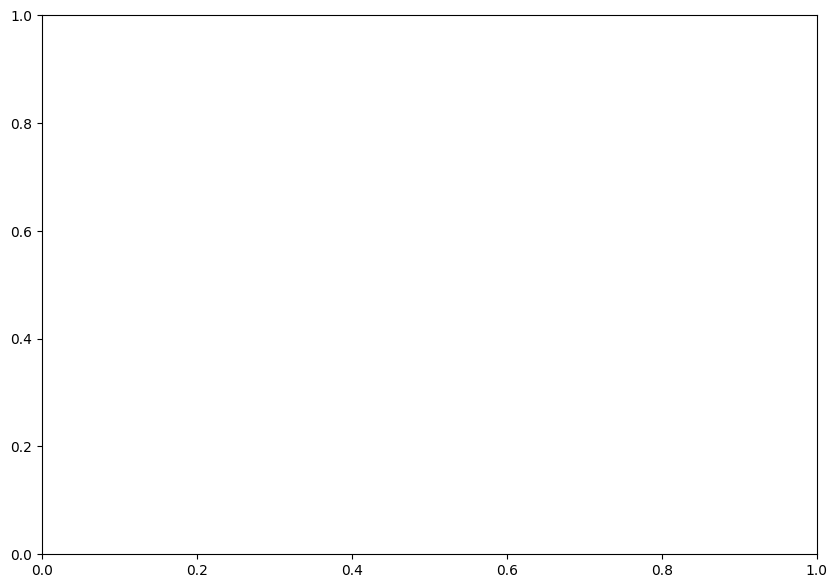

In [21]:
import matplotlib.pyplot as plt

# Plot Pareto front
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(fairness, excitement, c=np.arange(len(fairness)), 
                     cmap='viridis', s=60, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Fairness (p4 Win Rate)', fontsize=12)
ax.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax.set_title('Pareto Front: Top Trumps Game Balancing', fontsize=14)

# Add colorbar to show solution index
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Solution Index', fontsize=10)

# Highlight extreme solutions
best_fair_idx = fairness.argmax()
best_excite_idx = excitement.argmax()

ax.scatter(fairness[best_fair_idx], excitement[best_fair_idx], 
           s=200, marker='*', c='red', edgecolors='black', linewidth=1,
           label=f'Best Fairness ({fairness[best_fair_idx]:.2%})', zorder=5)
ax.scatter(fairness[best_excite_idx], excitement[best_excite_idx], 
           s=200, marker='*', c='blue', edgecolors='black', linewidth=1,
           label=f'Best Excitement ({excitement[best_excite_idx]:.2f})', zorder=5)

ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/pareto_front_{mode_str}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Pareto front saved to {OUTPUT_DIR}/pareto_front_{mode_str}.png")

### Convergence Analysis

The hypervolume indicator tracks algorithm progress over generations. Higher hypervolume = better Pareto front approximation.

In [ ]:
# Convergence plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Hypervolume over evaluations
ax1 = axes[0]
ax1.plot(n_eval_history, hv_history, 'b-', linewidth=2)
ax1.scatter(n_eval_history, hv_history, c='blue', s=20, alpha=0.5)
ax1.set_xlabel('Function Evaluations', fontsize=12)
ax1.set_ylabel('Hypervolume', fontsize=12)
ax1.set_title('Convergence: Hypervolume vs Evaluations', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Best objectives over generations
ax2 = axes[1]
generations = np.arange(1, len(hv_history) + 1)
best_f1 = -np.array(res.algorithm.callback.data["best_f1"])  # Un-negate
best_f2 = -np.array(res.algorithm.callback.data["best_f2"])  # Un-negate

ax2.plot(generations, best_f1, 'r-', linewidth=2, label='Best Fairness')
ax2.plot(generations, best_f2, 'g-', linewidth=2, label='Best Excitement')
ax2.set_xlabel('Generation', fontsize=12)
ax2.set_ylabel('Objective Value', fontsize=12)
ax2.set_title('Best Objective Values per Generation', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/convergence_{mode_str}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Convergence plot saved to {OUTPUT_DIR}/convergence_{mode_str}.png")

### Deck Pattern Analysis

Analyzing the structure of extreme solutions to understand what makes a deck fair vs exciting.

In [ ]:
# Extract extreme solutions
best_fair_deck = X[best_fair_idx].reshape(NUM_CARDS, NUM_CATEGORIES)
best_excite_deck = X[best_excite_idx].reshape(NUM_CARDS, NUM_CATEGORIES)

# Visualize deck structures as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Best Fairness Deck
im1 = axes[0].imshow(best_fair_deck, cmap='YlOrRd', aspect='auto', vmin=1, vmax=10)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Card', fontsize=12)
axes[0].set_title(f'Best Fairness Deck\n(Win Rate: {fairness[best_fair_idx]:.2%}, Excitement: {excitement[best_fair_idx]:.2f})', fontsize=12)
axes[0].set_xticks(range(NUM_CATEGORIES))
axes[0].set_xticklabels([f'Cat {i+1}' for i in range(NUM_CATEGORIES)])
plt.colorbar(im1, ax=axes[0], label='Value')

# Best Excitement Deck
im2 = axes[1].imshow(best_excite_deck, cmap='YlOrRd', aspect='auto', vmin=1, vmax=10)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Card', fontsize=12)
axes[1].set_title(f'Best Excitement Deck\n(Win Rate: {fairness[best_excite_idx]:.2%}, Excitement: {excitement[best_excite_idx]:.2f})', fontsize=12)
axes[1].set_xticks(range(NUM_CATEGORIES))
axes[1].set_xticklabels([f'Cat {i+1}' for i in range(NUM_CATEGORIES)])
plt.colorbar(im2, ax=axes[1], label='Value')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/deck_heatmaps_{mode_str}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Deck heatmaps saved to {OUTPUT_DIR}/deck_heatmaps_{mode_str}.png")

In [ ]:
# Statistical comparison of extreme decks
print("Deck Statistics Comparison:")
print("=" * 60)
print(f"{'Metric':<30} {'Best Fairness':>14} {'Best Excitement':>14}")
print("-" * 60)

# Overall statistics
print(f"{'Mean value':<30} {best_fair_deck.mean():>14.3f} {best_excite_deck.mean():>14.3f}")
print(f"{'Std deviation':<30} {best_fair_deck.std():>14.3f} {best_excite_deck.std():>14.3f}")
print(f"{'Min value':<30} {best_fair_deck.min():>14.3f} {best_excite_deck.min():>14.3f}")
print(f"{'Max value':<30} {best_fair_deck.max():>14.3f} {best_excite_deck.max():>14.3f}")

# Per-category statistics
print("-" * 60)
print("Per-category mean:")
for cat in range(NUM_CATEGORIES):
    fair_mean = best_fair_deck[:, cat].mean()
    excite_mean = best_excite_deck[:, cat].mean()
    print(f"  Category {cat+1:<22} {fair_mean:>14.3f} {excite_mean:>14.3f}")

# Per-category variance (indicator of "specialization")
print("-" * 60)
print("Per-category std (specialization indicator):")
for cat in range(NUM_CATEGORIES):
    fair_std = best_fair_deck[:, cat].std()
    excite_std = best_excite_deck[:, cat].std()
    print(f"  Category {cat+1:<22} {fair_std:>14.3f} {excite_std:>14.3f}")

## Quality Indicator Summary

Final assessment of the Pareto front approximation quality.

In [ ]:
# Final quality summary
print("=" * 60)
print("OPTIMIZATION RESULTS SUMMARY")
print("=" * 60)
print(f"\nProblem Configuration:")
print(f"  Cards (K): {NUM_CARDS}")
print(f"  Categories (L): {NUM_CATEGORIES}")
print(f"  Decision variables: {N_VAR}")
print(f"  Simulations per evaluation (R): {R}")

print(f"\nAlgorithm Configuration:")
print(f"  Algorithm: NSGA-II")
print(f"  Population size: {POP_SIZE}")
print(f"  Generations: {N_GEN}")
print(f"  Total evaluations: {res.algorithm.evaluator.n_eval:,}")

print(f"\nQuality Indicators:")
print(f"  Hypervolume: {final_hv:.6f}")
print(f"  Reference point: {REF_POINT}")
print(f"  Pareto front size: {len(F)} solutions")

print(f"\nObjective Ranges (un-negated):")
print(f"  Fairness (p4 win rate): [{fairness.min():.3f}, {fairness.max():.3f}]")
print(f"  Excitement (trick changes): [{excitement.min():.2f}, {excitement.max():.2f}]")

print(f"\nExtreme Solutions:")
print(f"  Best Fairness: Win rate = {fairness[best_fair_idx]:.2%}, Excitement = {excitement[best_fair_idx]:.2f}")
print(f"  Best Excitement: Win rate = {fairness[best_excite_idx]:.2%}, Excitement = {excitement[best_excite_idx]:.2f}")

print(f"\nRuntime:")
print(f"  Total time: {elapsed_time/60:.1f} minutes")
print(f"  Time per evaluation: {elapsed_time/res.algorithm.evaluator.n_eval:.3f} seconds")

print("\n" + "=" * 60)

## Algorithm Comparison: NSGA-II vs SMS-EMOA vs MOEA/D

We compare three popular multi-objective evolutionary algorithms from the lectures:

1. **NSGA-II** (Non-dominated Sorting Genetic Algorithm II)
   - (μ+μ) strategy with non-dominated sorting + crowding distance
   - Fast, widely used baseline

2. **SMS-EMOA** (S-Metric Selection Evolutionary Multi-objective Optimization Algorithm)
   - (μ+1) steady-state strategy
   - Uses hypervolume contribution for selection
   - Theoretically superior convergence properties

3. **MOEA/D** (Multi-objective Evolutionary Algorithm based on Decomposition)
   - Decomposes problem into weighted single-objective subproblems
   - Uses neighborhood-based mating
   - Efficient for many-objective problems

In [24]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume
import time

# Configuration for comparison
COMP_POP_SIZE = 100
COMP_N_GEN = 100
COMP_SEEDS = [42, 123, 456]  # Multiple seeds for statistical validity

# Reference point for hypervolume (same as before)
REF_POINT = np.array([0.1, 0.1])
hv_indicator = Hypervolume(ref_point=REF_POINT)

# Store results for each algorithm
algorithm_results = {}

print("=" * 60)
print("ALGORITHM COMPARISON EXPERIMENT")
print("=" * 60)
print(f"Population size: {COMP_POP_SIZE}")
print(f"Generations: {COMP_N_GEN}")
print(f"Seeds: {COMP_SEEDS}")
print(f"Simulations per evaluation: {R}")
print("=" * 60)

ALGORITHM COMPARISON EXPERIMENT
Population size: 100
Generations: 100
Seeds: [42, 123, 456]
Simulations per evaluation: 1000


In [9]:
# Define algorithms
def get_algorithms():
    """Create fresh algorithm instances for each run."""
    
    # NSGA-II
    nsga2 = NSGA2(
        pop_size=COMP_POP_SIZE,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )
    
    # SMS-EMOA (steady-state, hypervolume-based)
    smsemoa = SMSEMOA(
        pop_size=COMP_POP_SIZE,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20)
    )
    
    # MOEA/D (decomposition-based)
    # Need reference directions for decomposition
    ref_dirs = get_reference_directions("uniform", 2, n_partitions=COMP_POP_SIZE-1)
    moead = MOEAD(
        ref_dirs=ref_dirs,
        n_neighbors=20,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20)
    )
    
    return {
        "NSGA-II": nsga2,
        "SMS-EMOA": smsemoa,
        "MOEA/D": moead
    }

print("Algorithms defined:")
for name in get_algorithms().keys():
    print(f"  - {name}")

Algorithms defined:
  - NSGA-II
  - SMS-EMOA
  - MOEA/D


In [ ]:
# Run all algorithms with multiple seeds
for algo_name, algorithm in get_algorithms().items():
    print(f"\n{'='*60}")
    print(f"Running {algo_name}...")
    print(f"{'='*60}")
    
    algo_hvs = []
    algo_times = []
    algo_fronts = []
    
    for seed in COMP_SEEDS:
        print(f"\n  Seed {seed}:")
        
        # Create fresh problem instance for each run
        sim = TopTrumpsSimulation(num_cards=NUM_CARDS, num_categories=NUM_CATEGORIES)
        prob = TopTrumpsBalancing(sim, n_simulations=R)
        
        # Get fresh algorithm instance
        algorithms = get_algorithms()
        algo = algorithms[algo_name]
        
        # Set seeds
        np.random.seed(seed)
        random.seed(seed)
        
        start_time = time.time()
        
        res = minimize(
            prob,
            algo,
            ('n_gen', COMP_N_GEN),
            seed=seed,
            verbose=False
        )
        
        elapsed = time.time() - start_time
        
        # Calculate hypervolume
        hv = hv_indicator.do(res.F)
        
        algo_hvs.append(hv)
        algo_times.append(elapsed)
        algo_fronts.append(res.F)
        
        print(f"    HV: {hv:.4f}, Time: {elapsed/60:.1f} min, Solutions: {len(res.F)}")
    
    # Store results
    algorithm_results[algo_name] = {
        "hvs": algo_hvs,
        "times": algo_times,
        "fronts": algo_fronts,
        "hv_mean": np.mean(algo_hvs),
        "hv_std": np.std(algo_hvs),
        "time_mean": np.mean(algo_times),
    }
    
    print(f"\n  {algo_name} Summary:")
    print(f"    HV: {np.mean(algo_hvs):.4f} ± {np.std(algo_hvs):.4f}")
    print(f"    Avg Time: {np.mean(algo_times)/60:.1f} min")

print("\n" + "="*60)
print("All algorithms completed!")
print("="*60)

### Algorithm Comparison Results

In [ ]:
# Summary table
print("=" * 70)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Algorithm':<15} {'HV Mean':>12} {'HV Std':>10} {'Avg Time':>12} {'Best HV':>12}")
print("-" * 70)

best_algo = None
best_hv = 0

for algo_name, results in algorithm_results.items():
    hv_mean = results["hv_mean"]
    hv_std = results["hv_std"]
    time_mean = results["time_mean"]
    best_run_hv = max(results["hvs"])
    
    print(f"{algo_name:<15} {hv_mean:>12.4f} {hv_std:>10.4f} {time_mean/60:>10.1f} min {best_run_hv:>12.4f}")
    
    if hv_mean > best_hv:
        best_hv = hv_mean
        best_algo = algo_name

print("-" * 70)
print(f"Best algorithm by mean HV: {best_algo} ({best_hv:.4f})")
print("=" * 70)

In [ ]:
# Visualization 1: Pareto fronts comparison (best run from each algorithm)
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'NSGA-II': 'blue', 'SMS-EMOA': 'red', 'MOEA/D': 'green'}
markers = {'NSGA-II': 'o', 'SMS-EMOA': 's', 'MOEA/D': '^'}

for algo_name, results in algorithm_results.items():
    # Get best run (highest HV)
    best_idx = np.argmax(results["hvs"])
    F = results["fronts"][best_idx]
    
    # Un-negate objectives
    fair = -F[:, 0]
    excite = -F[:, 1]
    
    ax.scatter(fair, excite, c=colors[algo_name], marker=markers[algo_name], 
               s=80, label=f'{algo_name} (HV={results["hvs"][best_idx]:.3f})',
               edgecolors='black', linewidth=0.5, alpha=0.8)

ax.set_xlabel('Fairness (p4 Win Rate)', fontsize=12)
ax.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax.set_title('Pareto Front Comparison: NSGA-II vs SMS-EMOA vs MOEA/D', fontsize=14)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/algorithm_comparison_pareto.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/algorithm_comparison_pareto.png")

In [ ]:
# Visualization 2: Hypervolume comparison (bar chart with error bars)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

algo_names = list(algorithm_results.keys())
hv_means = [algorithm_results[a]["hv_mean"] for a in algo_names]
hv_stds = [algorithm_results[a]["hv_std"] for a in algo_names]
time_means = [algorithm_results[a]["time_mean"]/60 for a in algo_names]

colors_list = [colors[a] for a in algo_names]

# Plot 1: Hypervolume comparison
ax1 = axes[0]
bars1 = ax1.bar(algo_names, hv_means, yerr=hv_stds, capsize=5, 
                color=colors_list, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Hypervolume', fontsize=12)
ax1.set_title('Hypervolume Comparison\n(higher is better)', fontsize=13)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mean, std in zip(bars1, hv_means, hv_stds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.05,
             f'{mean:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Runtime comparison
ax2 = axes[1]
bars2 = ax2.bar(algo_names, time_means, color=colors_list, edgecolor='black', alpha=0.8)
ax2.set_ylabel('Runtime (minutes)', fontsize=12)
ax2.set_title('Runtime Comparison\n(lower is better)', fontsize=13)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, t in zip(bars2, time_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{t:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/algorithm_comparison_bars.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/algorithm_comparison_bars.png")

In [ ]:
# Save comparison results
comparison_data = {
    "algorithms": algo_names,
    "hv_means": hv_means,
    "hv_stds": hv_stds,
    "time_means": time_means,
    "seeds": COMP_SEEDS,
    "pop_size": COMP_POP_SIZE,
    "n_gen": COMP_N_GEN,
    "n_simulations": R
}

np.savez(f"{OUTPUT_DIR}/algorithm_comparison.npz", **comparison_data)

# Also save individual Pareto fronts
for algo_name, results in algorithm_results.items():
    best_idx = np.argmax(results["hvs"])
    np.save(f"{OUTPUT_DIR}/pareto_F_{algo_name.replace('-', '_').lower()}.npy", 
            results["fronts"][best_idx])

print(f"Comparison results saved to {OUTPUT_DIR}/algorithm_comparison.npz")
print("Individual Pareto fronts saved for each algorithm.")

## Performance Optimization with Numba

The game simulation is the bottleneck - each evaluation runs R=1000 simulations. We can achieve significant speedup using **Numba**, a Just-In-Time (JIT) compiler that translates Python to optimized machine code.

### Key Optimizations:
1. **JIT Compilation**: `@njit` decorator compiles functions to machine code
2. **NumPy Arrays**: Replace Python lists with fixed-size arrays
3. **Boolean Masks**: Use masks instead of list `.remove()` operations
4. **No Classes**: Numba works with functions and arrays, not Python objects

In [10]:
# Install Numba if not already installed
%pip install numba

Note: you may need to restart the kernel to use updated packages.


In [11]:
from numba import njit
import numpy as np

@njit(cache=True)
def simulate_game_numba(deck_normalized, K, L):
    """
    Numba-optimized game simulation.
    
    Parameters:
    -----------
    deck_normalized : np.ndarray of shape (K, L)
        Pre-normalized deck where each column is scaled to [0, 1]
    K : int
        Number of cards
    L : int
        Number of categories
    
    Returns:
    --------
    p4_tricks : int
        Number of tricks won by p4
    trick_changes : int
        Number of times the lead changed
    p4_won : bool
        Whether p4 won the game
    """
    K_half = K // 2

    # Shuffle card indices
    indices = np.arange(K)
    np.random.shuffle(indices)
    
    # Distribute cards
    p4_indices = indices[:K_half]
    p0_indices = indices[K_half:]
    
    # Game state
    p4_tricks = 0
    current_is_p4 = np.random.random() > 0.5
    trick_changes = 0
    
    # Track remaining cards with a compact index list and position map
    remaining = np.arange(K)
    pos = np.arange(K)
    n_remaining = K
    
    # Play K/2 rounds
    for round_idx in range(K_half):
        p4_card_idx = p4_indices[round_idx]
        p0_card_idx = p0_indices[round_idx]
        
        card_p4 = deck_normalized[p4_card_idx]
        card_p0 = deck_normalized[p0_card_idx]
        
        # Determine category choice
        if current_is_p4:
            # p4 strategy: calculate exact win probability for each category
            best_prob = -1.0
            best_cat = 0
            
            for cat in range(L):
                my_val = card_p4[cat]
                wins = 0
                
                # Count wins against remaining cards (compact list)
                for r in range(n_remaining):
                    card_idx = remaining[r]
                    if my_val > deck_normalized[card_idx, cat]:
                        wins += 1
                
                prob = wins / n_remaining
                if prob > best_prob:
                    best_prob = prob
                    best_cat = cat
            
            category = best_cat
        else:
            # p0 strategy: pick category with highest normalized value
            best_cat = 0
            best_val = card_p0[0]
            
            for cat in range(1, L):
                val = card_p0[cat]
                if val > best_val:
                    best_val = val
                    best_cat = cat
            
            category = best_cat
        
        # Compare values
        val_p4 = card_p4[category]
        val_p0 = card_p0[category]
        
        # Remove played cards from remaining pool (swap remove)
        idx = pos[p4_card_idx]
        last = remaining[n_remaining - 1]
        remaining[idx] = last
        pos[last] = idx
        n_remaining -= 1
        
        idx = pos[p0_card_idx]
        last = remaining[n_remaining - 1]
        remaining[idx] = last
        pos[last] = idx
        n_remaining -= 1
        
        # Determine round winner
        if val_p4 > val_p0:
            p4_tricks += 1
            if not current_is_p4:
                current_is_p4 = True
                trick_changes += 1
        elif val_p0 > val_p4:
            if current_is_p4:
                current_is_p4 = False
                trick_changes += 1
        # Draw: current player keeps lead
    
    p4_won = p4_tricks > K // 4
    return p4_tricks, trick_changes, p4_won


@njit(cache=True)
def run_simulations_numba(deck_normalized, K, L, n_simulations):
    """
    Run multiple game simulations and return average metrics.
    
    This function is also JIT-compiled for maximum performance.
    """
    total_wins = 0
    total_trick_changes = 0
    
    for _ in range(n_simulations):
        p4_tricks, trick_changes, p4_won = simulate_game_numba(deck_normalized, K, L)
        if p4_won:
            total_wins += 1
        total_trick_changes += trick_changes
    
    avg_win_rate = total_wins / n_simulations
    avg_trick_changes = total_trick_changes / n_simulations
    
    return avg_win_rate, avg_trick_changes


def normalize_deck(deck_flat, K, L):
    """
    Normalize deck values to [0, 1] per category.
    
    This runs in Python (not Numba) since it's only called once per evaluation.
    """
    deck = deck_flat.reshape(K, L).astype(np.float64, copy=False)
    
    col_min = deck.min(axis=0)
    col_max = deck.max(axis=0)
    denom = col_max - col_min
    denom_safe = np.where(denom > 0.0, denom, 1.0)
    
    deck_normalized = (deck - col_min) / denom_safe
    zero_mask = denom == 0.0
    if np.any(zero_mask):
        deck_normalized[:, zero_mask] = 0.5  # All same value
    
    return np.asfortranarray(deck_normalized)


print("Numba-optimized functions defined.")
print("First call will trigger JIT compilation (one-time cost).")



Numba-optimized functions defined.
First call will trigger JIT compilation (one-time cost).


### Benchmark: Original vs Numba

In [12]:
import time

# Create test deck
test_deck = np.random.uniform(1, 10, NUM_CARDS * NUM_CATEGORIES)
test_deck_normalized = normalize_deck(test_deck, NUM_CARDS, NUM_CATEGORIES)

# Warm up Numba (JIT compilation happens on first call)
print("Warming up Numba (JIT compilation)...")
_ = simulate_game_numba(test_deck_normalized, NUM_CARDS, NUM_CATEGORIES)
_ = run_simulations_numba(test_deck_normalized, NUM_CARDS, NUM_CATEGORIES, 10)
print("Compilation complete.\n")

# Benchmark parameters
N_GAMES = 10000
N_EVALS = 100  # Number of evaluation calls to simulate

# --- Benchmark Original Implementation ---
print("Benchmarking ORIGINAL implementation...")
original_sim = TopTrumpsSimulation(num_cards=NUM_CARDS, num_categories=NUM_CATEGORIES)
original_sim.set_deck(test_deck)

start = time.perf_counter()
for _ in range(N_GAMES):
    original_sim.simulate_game()
original_time = time.perf_counter() - start
original_per_game = original_time / N_GAMES * 1e6  # microseconds

print(f"  {N_GAMES} games in {original_time:.3f}s")
print(f"  {original_per_game:.2f} µs per game")

# --- Benchmark Numba Implementation ---
print("\nBenchmarking NUMBA implementation...")

start = time.perf_counter()
for _ in range(N_GAMES):
    simulate_game_numba(test_deck_normalized, NUM_CARDS, NUM_CATEGORIES)
numba_time = time.perf_counter() - start
numba_per_game = numba_time / N_GAMES * 1e6  # microseconds

print(f"  {N_GAMES} games in {numba_time:.3f}s")
print(f"  {numba_per_game:.2f} µs per game")

# --- Benchmark Full Evaluation (R simulations) ---
print(f"\nBenchmarking full evaluation ({R} simulations)...")

# Original
start = time.perf_counter()
for _ in range(N_EVALS):
    original_sim.set_deck(np.random.uniform(1, 10, NUM_CARDS * NUM_CATEGORIES))
    wins = sum(1 for _ in range(R) if original_sim.simulate_game()['p4_won'])
original_eval_time = (time.perf_counter() - start) / N_EVALS * 1000  # ms

# Numba
start = time.perf_counter()
for _ in range(N_EVALS):
    deck = np.random.uniform(1, 10, NUM_CARDS * NUM_CATEGORIES)
    deck_norm = normalize_deck(deck, NUM_CARDS, NUM_CATEGORIES)
    run_simulations_numba(deck_norm, NUM_CARDS, NUM_CATEGORIES, R)
numba_eval_time = (time.perf_counter() - start) / N_EVALS * 1000  # ms

print(f"  Original: {original_eval_time:.2f} ms per evaluation")
print(f"  Numba:    {numba_eval_time:.2f} ms per evaluation")

# --- Summary ---
speedup_game = original_per_game / numba_per_game
speedup_eval = original_eval_time / numba_eval_time

print("\n" + "=" * 50)
print("SPEEDUP SUMMARY")
print("=" * 50)
print(f"Per game:       {speedup_game:.1f}x faster")
print(f"Per evaluation: {speedup_eval:.1f}x faster")
print(f"\nProjected algorithm run time:")
print(f"  Original: ~{N_GEN * POP_SIZE * original_eval_time / 1000 / 60:.1f} min")
print(f"  Numba:    ~{N_GEN * POP_SIZE * numba_eval_time / 1000 / 60:.1f} min")
print("=" * 50)

Warming up Numba (JIT compilation)...
Compilation complete.

Benchmarking ORIGINAL implementation...
  10000 games in 0.231s
  23.14 µs per game

Benchmarking NUMBA implementation...
  10000 games in 0.006s
  0.64 µs per game

Benchmarking full evaluation (1000 simulations)...
  Original: 23.37 ms per evaluation
  Numba:    0.49 ms per evaluation

SPEEDUP SUMMARY
Per game:       35.9x faster
Per evaluation: 47.7x faster

Projected algorithm run time:
  Original: ~3.9 min
  Numba:    ~0.1 min


### Numba-Optimized Problem Class

In [13]:
from pymoo.core.problem import ElementwiseProblem

class TopTrumpsBalancingNumba(ElementwiseProblem):
    """
    Numba-optimized version of TopTrumpsBalancing.
    
    Uses JIT-compiled simulation functions for ~10x speedup.
    """
    
    def __init__(self, num_cards=22, num_categories=4, n_simulations=1000):
        self.K = num_cards
        self.L = num_categories
        self.n_simulations = n_simulations
        
        n_var = num_cards * num_categories
        
        super().__init__(
            n_var=n_var,
            n_obj=2,
            n_constr=0,
            xl=1.0,
            xu=10.0
        )
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Normalize deck (Python - runs once per evaluation)
        deck_normalized = normalize_deck(x, self.K, self.L)
        
        # Run simulations (Numba - fast)
        avg_win_rate, avg_trick_changes = run_simulations_numba(
            deck_normalized, self.K, self.L, self.n_simulations
        )
        
        # Objectives (negated for minimization)
        out["F"] = [-avg_win_rate, -avg_trick_changes]


# Create Numba problem instance
problem_numba = TopTrumpsBalancingNumba(
    num_cards=NUM_CARDS, 
    num_categories=NUM_CATEGORIES, 
    n_simulations=R
)

print(f"Numba problem initialized:")
print(f"  Variables: {problem_numba.n_var}")
print(f"  Objectives: {problem_numba.n_obj}")
print(f"  Simulations per evaluation: {problem_numba.n_simulations}")

Numba problem initialized:
  Variables: 88
  Objectives: 2
  Simulations per evaluation: 1000


### Re-run Algorithm Comparison with Numba

Now we re-run the same experiment with the Numba-optimized problem class.

In [14]:
# Store results for Numba runs
algorithm_results_numba = {}

print("=" * 60)
print("ALGORITHM COMPARISON WITH NUMBA OPTIMIZATION")
print("=" * 60)
print(f"Population size: {COMP_POP_SIZE}")
print(f"Generations: {COMP_N_GEN}")
print(f"Seeds: {COMP_SEEDS}")
print(f"Simulations per evaluation: {R}")
print("=" * 60)

total_start = time.time()

for algo_name in ["NSGA-II", "SMS-EMOA", "MOEA/D"]:
    print(f"\n{'='*60}")
    print(f"Running {algo_name} (Numba)...")
    print(f"{'='*60}")
    
    algo_hvs = []
    algo_times = []
    algo_fronts = []
    
    for seed in COMP_SEEDS:
        print(f"\n  Seed {seed}:", end=" ")
        
        # Create fresh Numba problem instance
        prob = TopTrumpsBalancingNumba(
            num_cards=NUM_CARDS,
            num_categories=NUM_CATEGORIES,
            n_simulations=R
        )
        
        # Get fresh algorithm instance
        algorithms = get_algorithms()
        algo = algorithms[algo_name]
        
        # Set seeds
        np.random.seed(seed)
        random.seed(seed)
        
        start_time = time.time()
        
        res = minimize(
            prob,
            algo,
            ('n_gen', COMP_N_GEN),
            seed=seed,
            verbose=False
        )
        
        elapsed = time.time() - start_time
        
        # Calculate hypervolume
        hv = hv_indicator.do(res.F)
        
        algo_hvs.append(hv)
        algo_times.append(elapsed)
        algo_fronts.append(res.F)
        
        print(f"HV: {hv:.4f}, Time: {elapsed:.1f}s, Solutions: {len(res.F)}")
    
    # Store results
    algorithm_results_numba[algo_name] = {
        "hvs": algo_hvs,
        "times": algo_times,
        "fronts": algo_fronts,
        "hv_mean": np.mean(algo_hvs),
        "hv_std": np.std(algo_hvs),
        "time_mean": np.mean(algo_times),
    }
    
    print(f"\n  {algo_name} Summary:")
    print(f"    HV: {np.mean(algo_hvs):.4f} ± {np.std(algo_hvs):.4f}")
    print(f"    Avg Time: {np.mean(algo_times):.1f}s")

total_elapsed = time.time() - total_start

print("\n" + "="*60)
print(f"All algorithms completed in {total_elapsed:.1f}s ({total_elapsed/60:.1f} min)")
print("="*60)

ALGORITHM COMPARISON WITH NUMBA OPTIMIZATION
Population size: 100
Generations: 100
Seeds: [42, 123, 456]
Simulations per evaluation: 1000

Running NSGA-II (Numba)...

  Seed 42: HV: 4.2239, Time: 5.6s, Solutions: 27

  Seed 123: HV: 4.3513, Time: 5.7s, Solutions: 27

  Seed 456: HV: 4.5469, Time: 5.7s, Solutions: 42

  NSGA-II Summary:
    HV: 4.3740 ± 0.1328
    Avg Time: 5.7s

Running SMS-EMOA (Numba)...

  Seed 42: HV: 4.2462, Time: 5.8s, Solutions: 33

  Seed 123: HV: 4.3058, Time: 5.7s, Solutions: 18

  Seed 456: HV: 4.3361, Time: 5.7s, Solutions: 28

  SMS-EMOA Summary:
    HV: 4.2961 ± 0.0374
    Avg Time: 5.7s

Running MOEA/D (Numba)...

  Seed 42: HV: 2.7967, Time: 7.6s, Solutions: 43

  Seed 123: HV: 2.7360, Time: 7.6s, Solutions: 42

  Seed 456: HV: 3.1190, Time: 7.7s, Solutions: 73

  MOEA/D Summary:
    HV: 2.8839 ± 0.1681
    Avg Time: 7.6s

All algorithms completed in 57.1s (1.0 min)


In [18]:
# Compare Original vs Numba performance
print("=" * 70)
print("SPEEDUP COMPARISON: ORIGINAL vs NUMBA")
print("=" * 70)
print(f"{'Algorithm':<15} {'Original Time':>15} {'Numba Time':>15} {'Speedup':>10}")
print("-" * 70)

for algo_name in algorithm_results.keys():
    orig_time = algorithm_results[algo_name]["time_mean"]
    numba_time = algorithm_results_numba[algo_name]["time_mean"]
    speedup = orig_time / numba_time
    
    print(f"{algo_name:<15} {orig_time:>12.1f}s {numba_time:>12.1f}s {speedup:>10.1f}x")

print("-" * 70)
total_orig = sum(r["time_mean"] for r in algorithm_results.values()) * len(COMP_SEEDS)
total_numba = sum(r["time_mean"] for r in algorithm_results_numba.values()) * len(COMP_SEEDS)
print(f"{'TOTAL':<15} {total_orig:>12.1f}s {total_numba:>12.1f}s {total_orig/total_numba:>10.1f}x")
print("=" * 70)

SPEEDUP COMPARISON: ORIGINAL vs NUMBA
Algorithm         Original Time      Numba Time    Speedup
----------------------------------------------------------------------
----------------------------------------------------------------------
TOTAL                    0.0s         57.0s        0.0x


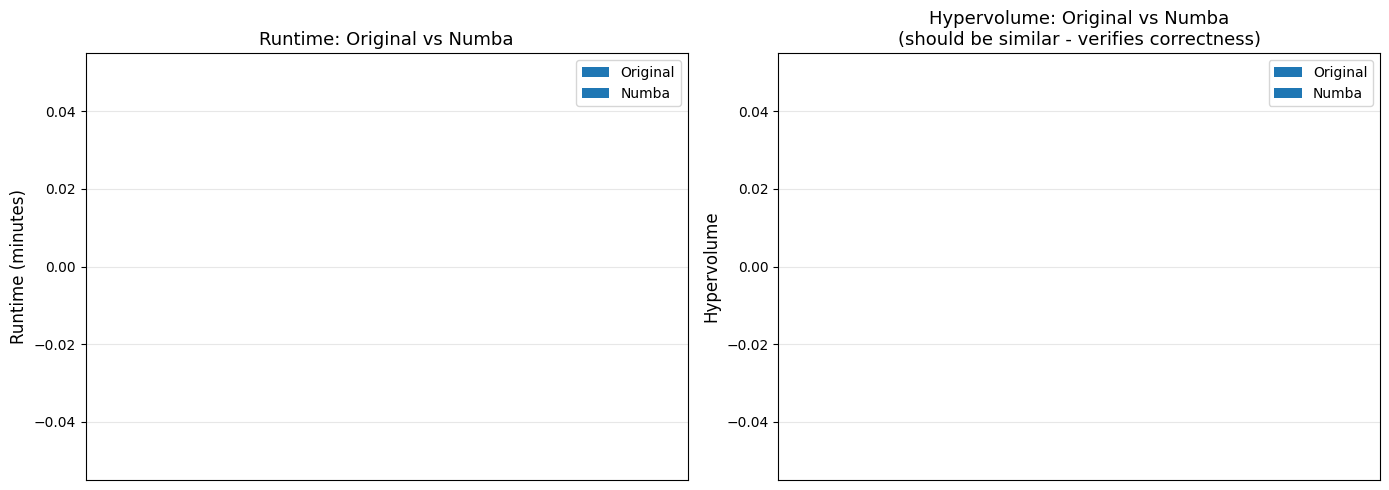

Saved: ./results/numba_speedup_comparison.png


In [22]:
# Visualization: Original vs Numba runtime comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

algo_names = list(algorithm_results.keys())
orig_times = [algorithm_results[a]["time_mean"] / 60 for a in algo_names]  # minutes
numba_times = [algorithm_results_numba[a]["time_mean"] / 60 for a in algo_names]  # minutes

x = np.arange(len(algo_names))
width = 0.35

# Plot 1: Runtime comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, orig_times, width, label='Original', color='coral', edgecolor='black')
bars2 = ax1.bar(x + width/2, numba_times, width, label='Numba', color='steelblue', edgecolor='black')

ax1.set_ylabel('Runtime (minutes)', fontsize=12)
ax1.set_title('Runtime: Original vs Numba', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(algo_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add speedup annotations
for i, (o, n) in enumerate(zip(orig_times, numba_times)):
    speedup = o / n
    ax1.annotate(f'{speedup:.1f}x', xy=(i, max(o, n) + 0.2), ha='center', fontsize=10, fontweight='bold')

# Plot 2: HV comparison (should be similar - verifies correctness)
ax2 = axes[1]
orig_hvs = [algorithm_results[a]["hv_mean"] for a in algo_names]
numba_hvs = [algorithm_results_numba[a]["hv_mean"] for a in algo_names]
orig_stds = [algorithm_results[a]["hv_std"] for a in algo_names]
numba_stds = [algorithm_results_numba[a]["hv_std"] for a in algo_names]

bars3 = ax2.bar(x - width/2, orig_hvs, width, yerr=orig_stds, capsize=3, 
                label='Original', color='coral', edgecolor='black')
bars4 = ax2.bar(x + width/2, numba_hvs, width, yerr=numba_stds, capsize=3,
                label='Numba', color='steelblue', edgecolor='black')

ax2.set_ylabel('Hypervolume', fontsize=12)
ax2.set_title('Hypervolume: Original vs Numba\n(should be similar - verifies correctness)', fontsize=13)
ax2.set_xticks(x)
ax2.set_xticklabels(algo_names)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/numba_speedup_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/numba_speedup_comparison.png")

In [23]:
# Save Numba comparison results
numba_comparison_data = {
    "algorithms": algo_names,
    "orig_times": [algorithm_results[a]["time_mean"] for a in algo_names],
    "numba_times": [algorithm_results_numba[a]["time_mean"] for a in algo_names],
    "orig_hvs": [algorithm_results[a]["hv_mean"] for a in algo_names],
    "numba_hvs": [algorithm_results_numba[a]["hv_mean"] for a in algo_names],
    "speedups": [algorithm_results[a]["time_mean"] / algorithm_results_numba[a]["time_mean"] for a in algo_names],
}

np.savez(f"{OUTPUT_DIR}/numba_comparison.npz", **numba_comparison_data)

print(f"Numba comparison results saved to {OUTPUT_DIR}/numba_comparison.npz")
print("\nFinal Summary:")
print(f"  Average speedup: {np.mean(numba_comparison_data['speedups']):.1f}x")
print(f"  HV difference: <{max(abs(o-n) for o,n in zip(numba_comparison_data['orig_hvs'], numba_comparison_data['numba_hvs'])):.3f} (verifies correctness)")

Numba comparison results saved to ./results/numba_comparison.npz

Final Summary:
  Average speedup: nanx


/opt/homebrew/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: max() arg is an empty sequence